# Gradient Boosting

## Introduction

<p style="line-height:1.75;font-size:16px">
Much like Adaboost, gradient boost trains many models in a gradual, additive and sequential manner. The major difference between the two is in how they identify the shortcomings of weak learners. While the Adaboost model identifies the shortcomings by using high weight data points, gradient boosting performs the same by using gradients in the loss function. Reminder, the loss function is a measure indicating how good are model’s coefficients are at fitting the underlying data. One of the biggest motivations for using gradient boosting is that it allows us to optimise a user specified cost function, instead of a loss function that usually offers less control and does not essentially correspond with real world applications.<br>
Ensemble methods like gradient boosting (and specifically XGBoost) have been shown to be extremely effective in wide variety of machine learning problems and are constantly at the top of Kaggle competitions.

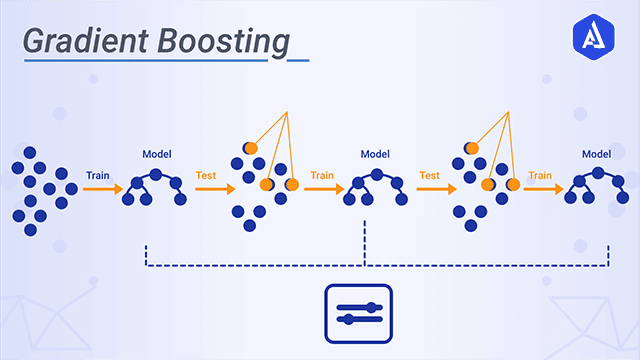

## Learn by Example

<p style="line-height:1.75;font-size:16px">
Once again, we'll take a toy example and work through it in order to understand how gradient boosting works. In this example we're going to try and classify which person liked the movie Trolls 2. Let's take a look at out dataset:

In [11]:
import pandas as pd

trolls = pd.read_csv('./data/trolls.csv')
trolls

,Like Popcorn,Age,Favorite Color,Loves Trolls 2
0,True,12,Blue,True
1,True,87,Green,True
2,False,44,Blue,False
3,True,19,Red,False
4,False,32,Green,True
5,False,14,Blue,True


<p style="line-height:1.75;font-size:16px">
Gradient boost starts with a leaf that contains an initial prediction for <b>all</b> of the samples.

<div style="line-height:1.75;background:#3464a2;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px">
<i class="fa fa-question" style="font-size:40px;color:#e6f1ff;"></i>
</div>
<div>
<p style="line-height:1.75;font-size:16px;background:#e6f1ff;padding:20px;border-radius:0px 0px 5px 5px">
What would you use as an initial prediction?
</p></div>

<p style="line-height:1.75;font-size:16px">
A good first guess would simply be the proportion (probability) of people who liked trolls 2 which is $\frac{2}{3}$. However, gradient boost uses something similar which is the log odds. So in our case it will be:<br>
<center><h3>
$Log~Odds=log(\frac{People~Who~Like~Trolls~2}{People~Who~Didn't~Like~Trolls~2})=log(\frac{4}{2})=0.693$
</h3>
</center>
<p style="line-height:1.75;font-size:16px">
Let's say that a new observation now comes in and we want to predict the probability that the person will like Trolls 2. We can't use the log odds directly since it's not a probability but we can transform it into one:<br>
<center><h3>
$P_{Loving~Trolls~2}=\frac{e^{log(odds)}}{1+e^{log(odds)}}=\frac{e^{0.693}}{1+e^{0.693}}= 0.66$
</h3>
</center>

<p style="line-height:1.75;font-size:16px">
Since $0.66 > 0.5$ we could say that this person would like Trolls 2. In fact, since we only have one leaf at the moment, we would say that for any person.

<div style="line-height:1.75;background:#f6e609;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px">
<i class="fa fa-lightbulb-o" style="font-size: 50px;color:#ffffcc;"></i>
</div>
<div>
<p style="line-height:1.75;background:#ffffcc;padding:20px;border-radius:0px 0px 5px 5px">
<span style="font-size:14px"><b>Decision Thresholds</b></span><br>
We used 0.5 as the threshold but we could really set it higher or lower, depeding on what we need. For example, if it was crucial that our model will make very little mistakes, we could set a threshold of 0.9. That way only when our model outputs a probability greater than 0.9 do we classify someone as liking Trolls 2. We'll get more into why this is important when we talk about imbalanced data.
</p></div>

<p style="line-height:1.75;font-size:16px">
Obviously predicting that everyone loves Trolls 2 is a bad idea and clearly wrong. We can quantify how bad this initial guess really is by calculating <b>pseudo residuals</b> - the difference between the observed and the predicted values.
<center><h3>
$Residual=Observed-Predicted$
</h3>
</center>

<p style="line-height:1.75;font-size:16px">
Let's calculate the residuals for all of our samples and store them in a new column.

In [12]:
trolls['Residual'] = trolls['Loves Trolls 2'] - 0.66
trolls

,Like Popcorn,Age,Favorite Color,Loves Trolls 2,Residual
0,True,12,Blue,True,0.34
1,True,87,Green,True,0.34
2,False,44,Blue,False,-0.66
3,True,19,Red,False,-0.66
4,False,32,Green,True,0.34
5,False,14,Blue,True,0.34


<p style="line-height:1.75;font-size:16px">
Now, using the features we have, we'll build a tress that predicts the <b>residual</b>. We won't go over the process of building a tress again (see the decision tree lesson for that) so let's just assume that our final tree looks likes this:

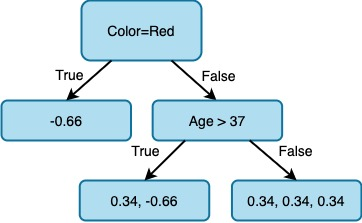

<p style="line-height:1.75;font-size:16px">
Since the predictions in the leaves were derived from probabilities but our initial guess is in the form of log odds we need to somehow transform them so that they can be added (more on that soon). A common transformation is this:

<center><h3>
$\frac{\sum\limits_i Residual_i}{\sum\limits_i(Previous~Probability_i\times(1 - Previous~Probability_i))}$
</h3>
</center>

<p style="line-height:1.75;font-size:16px">
Let's calculate this value for each of the leaves to see how it works:
<center><h3>
$\frac{-0.66}{0.66\times(1-0.66)}=-2.941$
</h3>
</center>
<p>
<center><h3>
$\frac{0.34-0.66}{0.66\times(1-0.66) + 0.66\times(1-0.66)}=-0.713$
</h3>
</center>
<p>
<center><h3>
$\frac{0.34-0.66}{0.66\times(1-0.66) + 0.66\times(1-0.66) + 0.66\times(1-0.66)}=1.515$
</h3>
</center>
<p style="line-height:1.75;font-size:16px">
Note that the denominator is similar since our initial probability is the same for all the examples at this point. That will change once we finish building our first tree.<br>
Let's update the values in our tree:

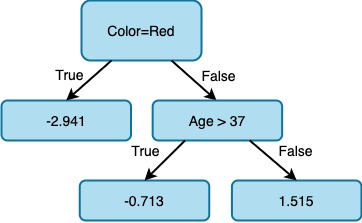

<p style="line-height:1.75;font-size:16px">
Now, similar to how we updated our sample weights in Adaboost, in gradient boost we need to update our residuals. We do this by adding the initial value and the current value multiplied by a learning rate. Let's set our learning rate to be 0.8. For each row in our data, we'll traverese the tree we just built to get it output value (the value in the leaf), multiply that by our learning rate, and add the initial log odds we calculated at the beginning 0.693. Let's calculate the value for the first person in our data:
<center><h3>
$log~odds_1=0.693 + 0.8\cdot 1.515=1.904$
</h3>
</center>
<p style="line-height:1.75;font-size:16px">
And we'll convert it into a probability like we did earlier:
<center><h3>
$P=\frac{e^{log(odds)}}{1+e^{log(odds)}}=\frac{e^{1.904}}{1+e^{1.904}}= 0.87$
</h3>
</center>
<p style="line-height:1.75;font-size:16px">
Recall that we started with an initial probability of 0.66 and now we're at 0.87. This is a step in the right direction since this person loves Trolls 2.

In [42]:
trolls['Predicted Probability'] = [0.87, 0.53, 0.53, 0.16, 0.87, 0.87]
trolls

,Like Popcorn,Age,Favorite Color,Loves Trolls 2,Residual,Predicted Probability
0,True,12,Blue,True,0.34,0.87
1,True,87,Green,True,0.34,0.53
2,False,44,Blue,False,-0.66,0.53
3,True,19,Red,False,-0.66,0.16
4,False,32,Green,True,0.34,0.87
5,False,14,Blue,True,0.34,0.87


<p style="line-height:1.75;font-size:16px">
We can now update the residual by calculating the difference between the observed and predicted values:

In [43]:
trolls['Residual'] = trolls['Loves Trolls 2'] - trolls['Predicted Probability']
trolls

,Like Popcorn,Age,Favorite Color,Loves Trolls 2,Residual,Predicted Probability
0,True,12,Blue,True,0.13,0.87
1,True,87,Green,True,0.47,0.53
2,False,44,Blue,False,-0.53,0.53
3,True,19,Red,False,-0.16,0.16
4,False,32,Green,True,0.13,0.87
5,False,14,Blue,True,0.13,0.87


<p style="line-height:1.75;font-size:16px">
Now we can start all over and build a new tree, this time with different probabilities for each person. Let's assume that this is the tree that was built:

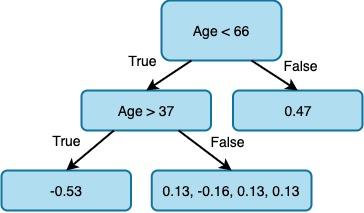

<p style="line-height:1.75;font-size:16px">
Once we've finished building all of our trees, when we want to predict a new observation, we simply start with the initial log odds, get the log odds for that person from every tree (scaled by the learning rate) and transform that value into a probability.

<div style="line-height:1.75;background:#1e7b1e;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px"><i class="fa fa-pencil" style="font-size:40px;color:#c1f0c1;"></i>
</div>
<div>
<p style="line-height:1.75;font-size:16px;background:#c1f0c1;padding:20px;border-radius:0px 0px 5px 5px">
Assuming that our gradient boost classifier only uses these two trees, which of the following people would like Trolls 2? <br>
This time, when calculating the log odds, you'll not only add the initial log odds but also the ones from the first tree before transforming the value into a probabilty.
<table>
<tr>
    <th>
      id
    </th>
      <th>
     Like Popcorn
    </th>
    <th>
     Age
    </th>
    <th>
    Favorite Color
    </th>
</tr>
<tr>
    <td>
     1
    </td>
    <td>
      True
    </td>
    <td>
      25
    </td>
    <td>
      Blue
    </td>
<tr>
<tr>
    <td>
     2
    </td>
    <td>
      True
    </td>
    <td>
      40
    </td>
    <td>
      Red
    </td>
<tr>
<tr>
    <td>
     3
    </td>
    <td>
      False
    </td>
    <td>
      91
    </td>
    <td>
      Green
    </td>
<tr>
</table>
</p>
</div>

<p style="line-height:1.75;font-size:16px">
We'll start by calculating the log odds of the right leaf of $Age > 37$:
<center><h3>
$log~odds_{Age\leq37}=\frac{0.13 + 0.13 + 0.13 - 0.16}{0.87(1-0.87)+0.87(1-0.87)+0.87(1-0.87)+0.16(1-0.16)}=0.485$
</h3>
</center>
<p style="line-height:1.75;font-size:16px">
And now the log odds of the left leaf of $Age > 37$:
<center><h3>
$log~odds_{Age>37}=\frac{-0.53}{0.53(1-0.53)}=-2.127$
</h3>
</center>
<p style="line-height:1.75;font-size:16px">
Now we can calculate the log odds for each observation in the table:
<center><h3>
$log~odds_{id=1}=0.693 + 0.8\cdot1.515+0.8\cdot0.485=2.292$
</h3>
</center>
<center><h3>
$log~odds_{id=2}=0.693 + 0.8\cdot-2.941+0.8\cdot-2.2127=-3.429$
</h3>
</center>
<p style="line-height:1.75;font-size:16px">
And finally we can translate the log odds into probabilities:
<center>
<h3>
$P(likes~Trolls~2)_1=\frac{e^{2.292}}{1+e^{2.292}}=0.908$
</h3>
</center>
<center>
<h3>
$P(likes~Trolls~2)_2=\frac{e^{-3.429}}{1+e^{-3.429}}=0.031$
</h3>
</center>

## Gradient Boosting with SKlearn

<p style="line-height:1.75;font-size:16px">
We'll use the titantic dataset to run a gradient boosting classifier.

In [13]:
# Imports
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Read the data './data/titanic_train.csv'
data = pd.read_csv('data/titanic_train.csv')

# Prepare the training data
data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
data.dropna(inplace=True)
data = pd.get_dummies(data)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(data.drop('Survived', axis=1), data['Survived'], train_size=0.8)


# Iterate over different learning rates and fit a classifier
for lr in [0.01, 0.1, 1, 2]:
    gbc = GradientBoostingClassifier(learning_rate=lr, min_samples_leaf=5)
    gbc.fit(X_train, y_train)
    # Print the classifier's score
    print(f'Train ({lr}): {gbc.score(X_train, y_train)}')
    print(f'Test ({lr}): {gbc.score(X_test, y_test)}')
    y_pred = gbc.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    
# Train a new classifier, with the best learning rate according to results
gbc = GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=5)
gbc.fit(X_train, y_train)
# Print the confusion matrix and classification report for this classifier
y_pred = gbc.predict(X_test)
print(confusion_matrix(y_test, y_pred))

Train (0.01): 0.843585237258348
Test (0.01): 0.8181818181818182
[[86  9]
 [17 31]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        95
           1       0.78      0.65      0.70        48

    accuracy                           0.82       143
   macro avg       0.80      0.78      0.79       143
weighted avg       0.81      0.82      0.81       143

Train (0.1): 0.9314586994727593
Test (0.1): 0.8461538461538461
[[85 10]
 [12 36]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.89        95
           1       0.78      0.75      0.77        48

    accuracy                           0.85       143
   macro avg       0.83      0.82      0.83       143
weighted avg       0.84      0.85      0.85       143

Train (1): 1.0
Test (1): 0.7272727272727273
[[68 27]
 [12 36]]
              precision    recall  f1-score   support

           0       0.85      0.72      0.78        95
         

# XGBoost

## Introduction

<p style="line-height:1.75;font-size:16px">
XGBoost (eXtreme Gradient Boost) is an implementation of gradient boosted decision trees designed for speed and performance. It has recently been dominating applied machine learning and Kaggle competitions for structured or tabular data and is very popular amongst machine learning practitioners. XGBoost is a software library that you can download and install on your machine, then access from a variety of interfaces including Python.

## Learn by Example

<p style="line-height:1.75;font-size:16px">
We're going to walk through the steps of how XGBoost works by looking at a super simple regression example. Bear in mind that XGBoost wsa created for dataset much larger and more complex than our example. That being said, the example should give you a better understanding of how the algorithm works.<br>
Imagine we have the following data about drug dosage and its effectiveness:

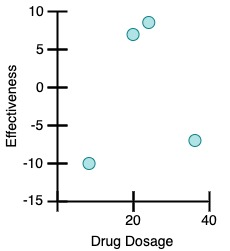

<p style="line-height:1.75;font-size:16px">
Similar to gradient boosting, we start with an initial prediction: $P=0.5$ (this is true for both regression and classification) and start building our tree. In the case of XGBoost we start with a left that has all of the residuals in it.

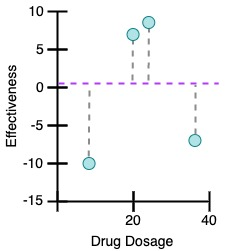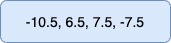

<p style="line-height:1.75;font-size:16px">
Now, we'll calculate a similarity score. This score will help us later determine if we need to split the leaf further.
<center><h3>
$Similarity~Score=\frac{Sum~of~Residuals~Squared}{Number~of~Residuals+\lambda}$
</h3>
</center>
<p style="line-height:1.75;font-size:16px">
where $\lambda$ is a regularization parameter (more on that later). Let's set $\lambda=0$ for now and plug in the numbers from our leaf into the formula:
<center><h3>
$Similarity~Score=\frac{(-10.5+6.5+7.5-7.5)^2}{4+0}=\frac{(-4)^2}{4}=4$
</h3>
</center>
<p style="line-height:1.75;font-size:16px">
Notice that we only square the residuals <b>after</b> adding them so positive and negative residuals cancel each other out.<br>
The next step is to figure out if we could do a better job by splitting the leaf into two. To do this, we'll look at the two most left samples and calculate their average dosage: $\frac{20+10}{2}$ = 15

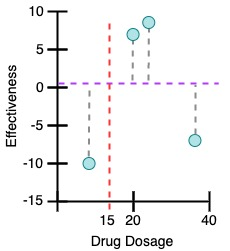

<p style="line-height:1.75;font-size:16px">
Now, we build a tree where the root is the the criterion $dosage<15$ and see how that has split the data.

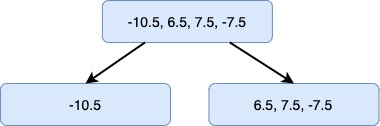

<p style="line-height:1.75;font-size:16px">
And now we'll calculate the similarity score for each leaf (let's call the left and right):
<center><h3>
$Similarity~Score_{left}=\frac{(-10.5)^2}{1+0}=110.25$
</h3>
</center>
<p>
<center><h3>
$Similarity~Score_{right}=\frac{(-6.5+7.5-7.5)^2}{3+0}=14.08$
</h3>
</center>

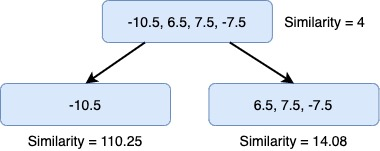

<p style="line-height:1.75;font-size:16px">
We can see that when the residuals in the leaf are very different, they cancel each other out and the similarity score is small. We can see that in this case the leaves do a better job of clustering similar residuals together than the root but how do we qunatify it? We use a metric called <b>gain</b>:
<center><h3>
$Gain=Similarity~Score_{left}+Similarity~Score_{right}-Similarity~Score_{root}$
</h3>
</center>
<p>
<center><h3>
$Gain_{dosage<15}=110.25+14.06-4=120.33$
</h3>
</center>
<p style="line-height:1.75;font-size:16px">
Now we now the gain for this threshold let's calculate the gain for other thresholds as well.
<center><h3>
$Gain_{dosage<22.5}=4$
</h3>
</center>
<p>
<center><h3>
$Gain_{dosage<30}=56.33$
</h3>
</center>
<p style="line-height:1.75;font-size:16px">
Since $Gain_{dosage<15}$ is the highest one, we'll use it as our root in the new tree.

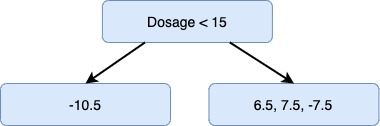

<p style="line-height:1.75;font-size:16px">
As you can see, we can't split the left node any further but we can split the right one. From our earlier calculations we know that there are two possible thresholds: 22.5 and 30. Let's try 22.5 first.

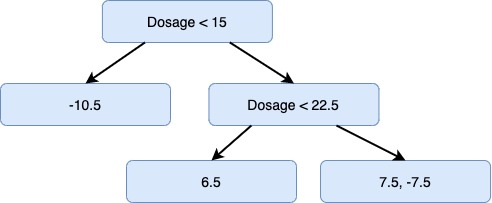

<p style="line-height:1.75;font-size:16px">
Now we'll calculate the similarity score for each of the child nodes and then the gain (recall that we've calculated the similarity score of the parent node earlier, it was 14.08).
<center><h3>
$Similarity~Score_{left}=\frac{6.5^2}{1+0}=42.25$
</h3>
</center>
<p>
<center><h3>
$Similarity~Score_{right}=\frac{(7.5-7.5)^2}{2+0}=0$
</h3>
</center>
<p>
<center><h3>
$Gain_{dosage<22.5}=42.5+0-14.08=28.17$
</h3>
</center>
<p style="line-height:1.75;font-size:16px">
Similarly we'll calculate the similarity scores and gain for a threshold of $dosage<30$ and get:
<center><h3>
$Gain_{dosage<30}=140.17$
</h3>
</center>
<p style="line-height:1.75;font-size:16px">
Since the gain is larger for the threshold of $dosage<30$ we'll use that as our next branch in the tree:

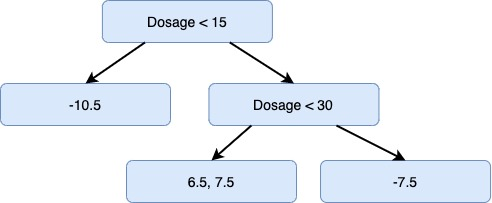

<p style="line-height:1.75;font-size:16px">
Technically we could continue and try to split the left node again but for the sake of the example let's limit our tree depth to 2. 
<p><br>
<p style="line-height:1.75;font-size:16px">
<b>Pruning</b><br>
<p style="line-height:1.75;font-size:16px">
The next step is to prune (remove nodes from) the tree.

<div style="line-height:1.75;background:#3464a2;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px">
<i class="fa fa-question" style="font-size:40px;color:#e6f1ff;"></i>
</div>
<div>
<p style="line-height:1.75;font-size:16px;background:#e6f1ff;padding:20px;border-radius:0px 0px 5px 5px">
Why would we want to prune the tree?
</p></div>

<p style="line-height:1.75;font-size:16px">
By default, XGBoost builds the tree to its maximum depth so that is doesn't have to slow down and check its regularization parameters. Once it's done building the tree however it will go from the bottom up and do som e pruning if needed. This mechanism helps the tree to reduce overfitting.<br>
The way pruning works is by setting a paramter $\gamma$ to a certain value. For our example let's set $\gamma=130$. Then, starting from the lowest branch in the tree, we calculate the difference between the gain or the branch and $\gamma$. If $gain-\gamma<0$ we will remove the branch and move up to the parent branch. If $gain-\gamma > 0$ we won't remove the branch and won't move up to the parent.<br>
In our current example the gain for the lowest branch is 140.17 which is greater than $\gamma$. If however, we were to set $\gamma=150$ then this branch would have been pruned and we would have moved to the parent branch. The parent branch has a gain of 120.33 which is less than 150 so we'd remove it as well and we would have been left only with the original prediction we started with.

<p style="line-height:1.75;font-size:16px">
<b>The effect of $\lambda$</b><br>
Earlier we mentioned $\lambda$ but set it to 0. Let's see what it would have done to the gain score if we had set $\lambda=1$.

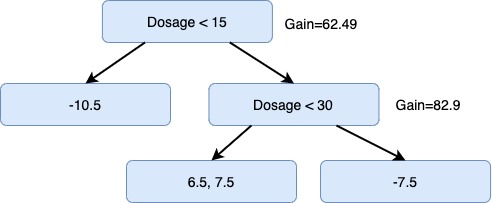

<p style="line-height:1.75;font-size:16px">
The gains have become significantly smaller. Even with our smaller value of $\gamma=130$ the entire tree would have been pruned. The takeaway from this is that when $\lambda>0$ the values for gain are smaller and it's easier to prune the tree. Since $\lambda$ affects the gain, it should be noted that certain values of $\lambda$ could cause the gain to become negative and thus be pruned even if $\gamma>0$.

<p style="line-height:1.75;font-size:16px">
<b>Predicting the Output</b>

<p style="line-height:1.75;font-size:16px">
The output value for the leaf nodes is calculated much like the similarity score except we don't square the residuals. 
<center><h3>
$Output~Value=\frac{Sum~of~Residuals}{Number~of~Residuals+\lambda}$
</h3>
</center>

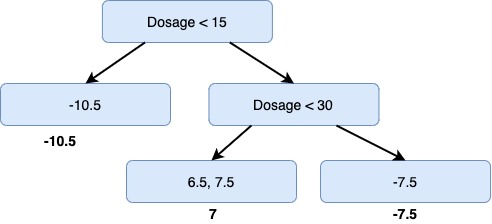

<p style="line-height:1.75;font-size:16px">
Note that if we had set $\lambda=1$ the output values would have also been smaller meaning that each node contributed less to the final prediction. This is how $\lambda$ reduces the prediction's sensitivity to a single observation.<br>
We are now finally ready to make a prediction. Much like gradient boost, in order to calculate the final prediction we take our initial prediction and add the values from all of the trees scaled by a learning rate parmeter $\epsilon$. We'll set $\epsilon=0.3$.<br>
Now, if we look at our prediction for $dosage=10$ we will get:
$P_{dosage=10}=0.5 + (0.3\cdot -10.5)=-2.65$. If we look at the plot we can see that the residual has gotten smaller do we're in the right direction.<br>
Now we can build another tree based on these new residuals and start the process all over again.

## Pros & Cons

<p style="line-height:1.75;font-size:16px">
<b>Pros</b>
1\. Very fast compared to other gradient boosting algorithms.
2\. Consistently a top performer on various machine learning problems.
3\. Parallelizable so it can scale well.
<p style="line-height:1.75;font-size:16px">
<b>Cons</b>
1\. Like other boosting algorithms needs to be tuned to avoid overfitting.
2\. Similar to other decision tree based models, it can extrapolate values.

## XGBoost in Python

In [2]:
# Getting XGBoost on your computer
!pip install xgboost

     |████████████████████████████████| 1.2 MB 904 kB/s eta 0:00:01
You should consider upgrading via the '/Users/gadmarkovits/Anaconda/anaconda3/bin/python -m pip install --upgrade pip' command.


In [10]:
import pandas as pd
from sklearn.datasets import load_boston

housing = load_boston()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['target'] = pd.Series(housing.target)
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [33]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

X = df.drop('target', axis=1)
y = df['target']

models = {'XGBoost': XGBRegressor, 
          'Linear Regression': LinearRegression
         }

for model_name, model in models.items():
    model = model()
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=10)
    scores = abs(scores)
    print(f'{model_name} Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

XGBoost Mean RMSE: 0.193 (0.050)
Linear Regression Mean RMSE: 0.247 (0.038)


## Exercise

<div style="line-height:1.75;background:#1e7b1e;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px"><i class="fa fa-pencil" style="font-size:40px;color:#c1f0c1;"></i>
</div>
<div>
<p style="line-height:1.75;font-size:16px;background:#c1f0c1;padding:20px;border-radius:0px 0px 5px 5px">
Train an <b>XGBoostClassifier</b> on the diabetes dataset from sklearn(`load_breast_cancer`). Compare your model's performance to another classification method of your choosing.
</p>
</div>

In [32]:
import pandas as pd
from sklearn.datasets import load_breast_cancer

bc = load_breast_cancer()
df = pd.DataFrame(bc.data, columns=bc.feature_names)
df['target'] = pd.Series(bc.target)
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

X = df.drop('target', axis=1)
y = df['target']

models = {'XGBoost': XGBClassifier, 
          'Logistic Regression': LogisticRegression
         }

for model_name, model in models.items():
    model = model()
    scores = cross_val_score(model, X, y, scoring='accuracy', n_jobs=-1, cv=10)
    scores = abs(scores)
    print(f'{model_name} Mean Accuracy: %.3f (%.3f)' % (scores.mean(), scores.std()) )

XGBoost Mean Accuracy: 0.979 (0.017)
Logistic Regression Mean Accuracy: 0.939 (0.016)
